`fgl` - датасет содержащий 214 строк данных о стекле, собранном в ходе судебно-медицинской экспертизы.

Датасет содержит данный набор атрибутов и тип данных относящийся к данному атрибуту:

| Имя | Тип | Описание |
|----|----|----|
| RI | float | refractive index или показатель преломления |
| Na | float | sodium
| Mg | float | manganese
| Al | float | aluminium
| Si | float | silicon
| K | float | potassium
| Ca | float | calcium
| Ba | float | barium
| Fe | float | iron
| type | class | тип фрагмента

Первоначально фрагменты были разделены на семь типов, один из которых отсутствовал в этом наборе данных. Встречаются следующие категории: оконное флоат-стекло (WinF: 70), оконное не-флоат-стекло (WinNF: 76), оконное стекло транспортного средства (Veh: 17), контейнеры (Con: 13), посуда (Tabl: 9) и фары транспортных средств. (Head: 29).

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [34]:
data_path = './data/data.csv'

In [35]:
df = pd.read_csv(data_path, sep=';')

In [74]:
classes = list(df['type'].unique())
class_count = len(classes)

In [36]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
type     object
dtype: object

In [37]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,WinF
1,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,WinF
2,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,WinF
3,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,WinF
4,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,WinF


Атрибуты:  RI, Na, Mg, Al, Si, K, Ca, Ba, Fe


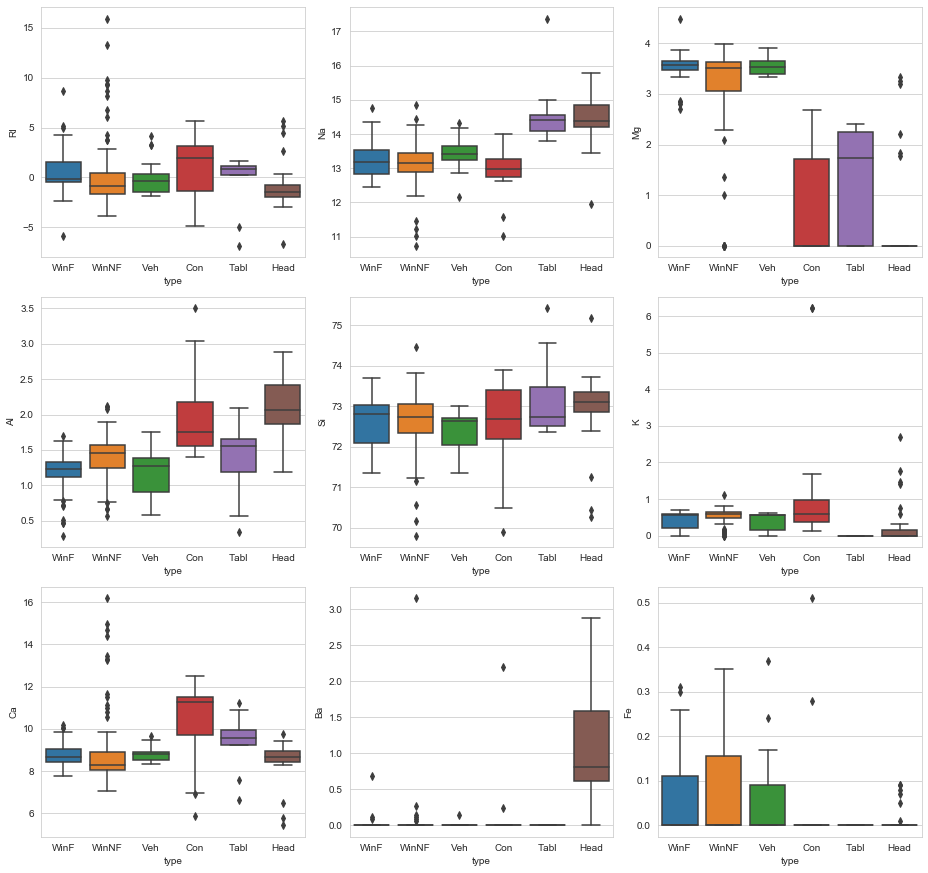

In [43]:
l = list(df.columns[:-1])
print("Атрибуты: ", ', '.join(l))
number_of_rows=len(l)
plt.figure(figsize=(13,40))
for i in range(number_of_rows):
    plt.subplot(number_of_rows + 1,3,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x='type', y=l[i], data=df, orient='v')
    plt.tight_layout()

Из представленных выше графиков можно заметить несколько моментов:
1. Для каждого типа стекла сильно различается их содержание
2. Содержание некоторых веществ порой настолько мало, что по наличию или отсутвию вещества можно отсечь большинство вариантов классов

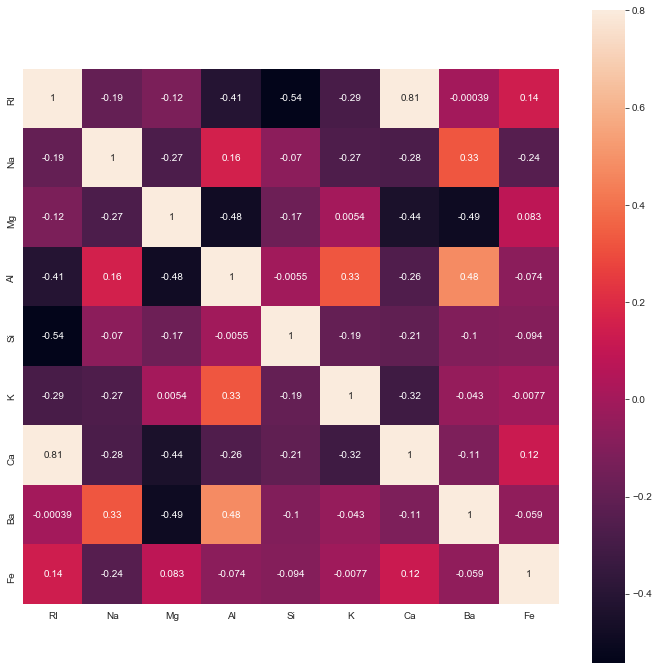

In [54]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

Из приведенной выше матрицы корреляции можно увидеть интересный момент - показатель преломления. У RI (показатель преломления) и кальция есть зависимость.
Возможно, количество кальция как-то влияет на показатель приломления.


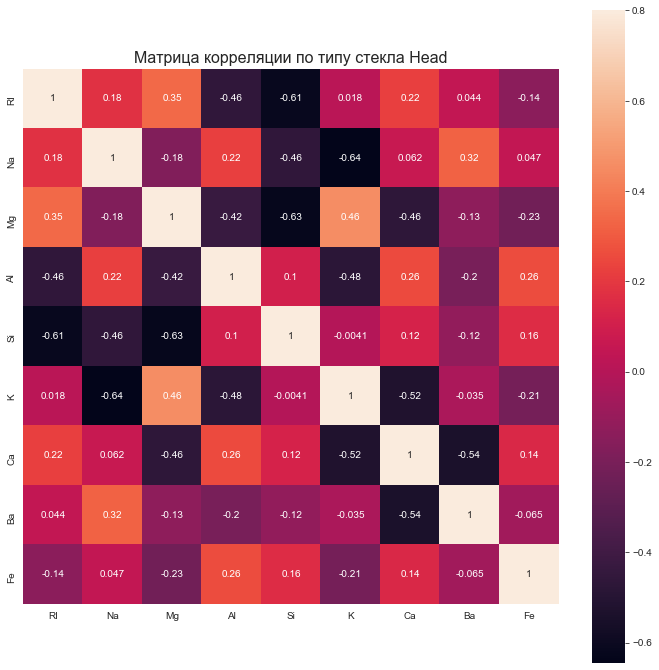

In [65]:
val = 'Head'
corrmat = df[df['type'] == val].corr()
f, ax = plt.subplots(figsize=(12, 12))
ax.set_title(f'Матрица корреляции по типу стекла {val}', fontdict={'fontsize': 16})
sns.heatmap(corrmat, vmax=.8, square=True, annot=True,)


Путем эксперементов было найдено, что у всех типов стекла имеется высокую зависимость Кальция и RI. Кроме одно типа стекла - Head. Скорее всего это связанно с тем что в это стекло для автомобильных фар добавляют краситель, другие хим. элементы или меняют структуру из-за чего у этого стекла меняется коэфициент преломления. К тому же, по самым первым графикам диаграммам размаха, можно заметить что Head имеет значительно меньшее значение RI чем у других типов стекла, из-за чего зависимость кальция и ri падает.

### Класс задачи
Далее нужно определить класс задачи. У нас задача классификации. Для подобной задачи хорошо подойдут следующие алгоритмы машинного обучения: 
1. Деревья и их вариации
2. Метод К-средних

Можно использовать и другие алгоритмы для решения задачи классификации, но эти являются основнымы и для этой задачи скорее всего выдадут достаточно стабильный и качественный результат.

### Обучение и тестирование моделей

In [66]:
# делим данные на тестовую и тренировочную выборку
X_data, y_data = df.loc[:, :df.columns[-2]], df['type']
X_train,  X_test,  y_train,  y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)

#### Методика тестирования
Для оценки качества модели будет расчитывать набор метрик:
* accuracy — доля правильных ответов алгоритма
* recall - полнота, доля истинно положительных классификаций
* precision - точностью, доля правильных ответов модели в пределах класса

In [95]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def calc_error(y_res, y_predict):
    print('Правильность:', accuracy_score(y_res, y_predict))
    print('Полнота взвешенная:', recall_score(y_res, y_predict, average='weighted'))
    print('Полнота глобальная:', recall_score(y_res, y_predict, average='macro'))
    print('Точность взвешенная:', precision_score(y_res, y_predict, average='weighted'))
    print('Точность глобальная:', precision_score(y_res, y_predict, average='macro'))

Протестируем DecisionTreeClassifier и KNeighborsClassifier

In [96]:
model = KNeighborsClassifier(n_neighbors=class_count)
model.fit(X_train, y_train)
calc_error(y_test, model.predict(X_test))

Правильность: 0.7441860465116279
Полнота взвешенная: 0.7441860465116279
Полнота глобальная: 0.6259920634920635
Точность взвешенная: 0.7586563307493539
Точность глобальная: 0.7240740740740742


In [152]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
calc_error(y_test, model.predict(X_test))

Правильность: 0.7674418604651163
Полнота взвешенная: 0.7674418604651163
Полнота глобальная: 0.7884199134199134
Точность взвешенная: 0.8125322997416019
Точность глобальная: 0.799074074074074


Визиализируем дерево

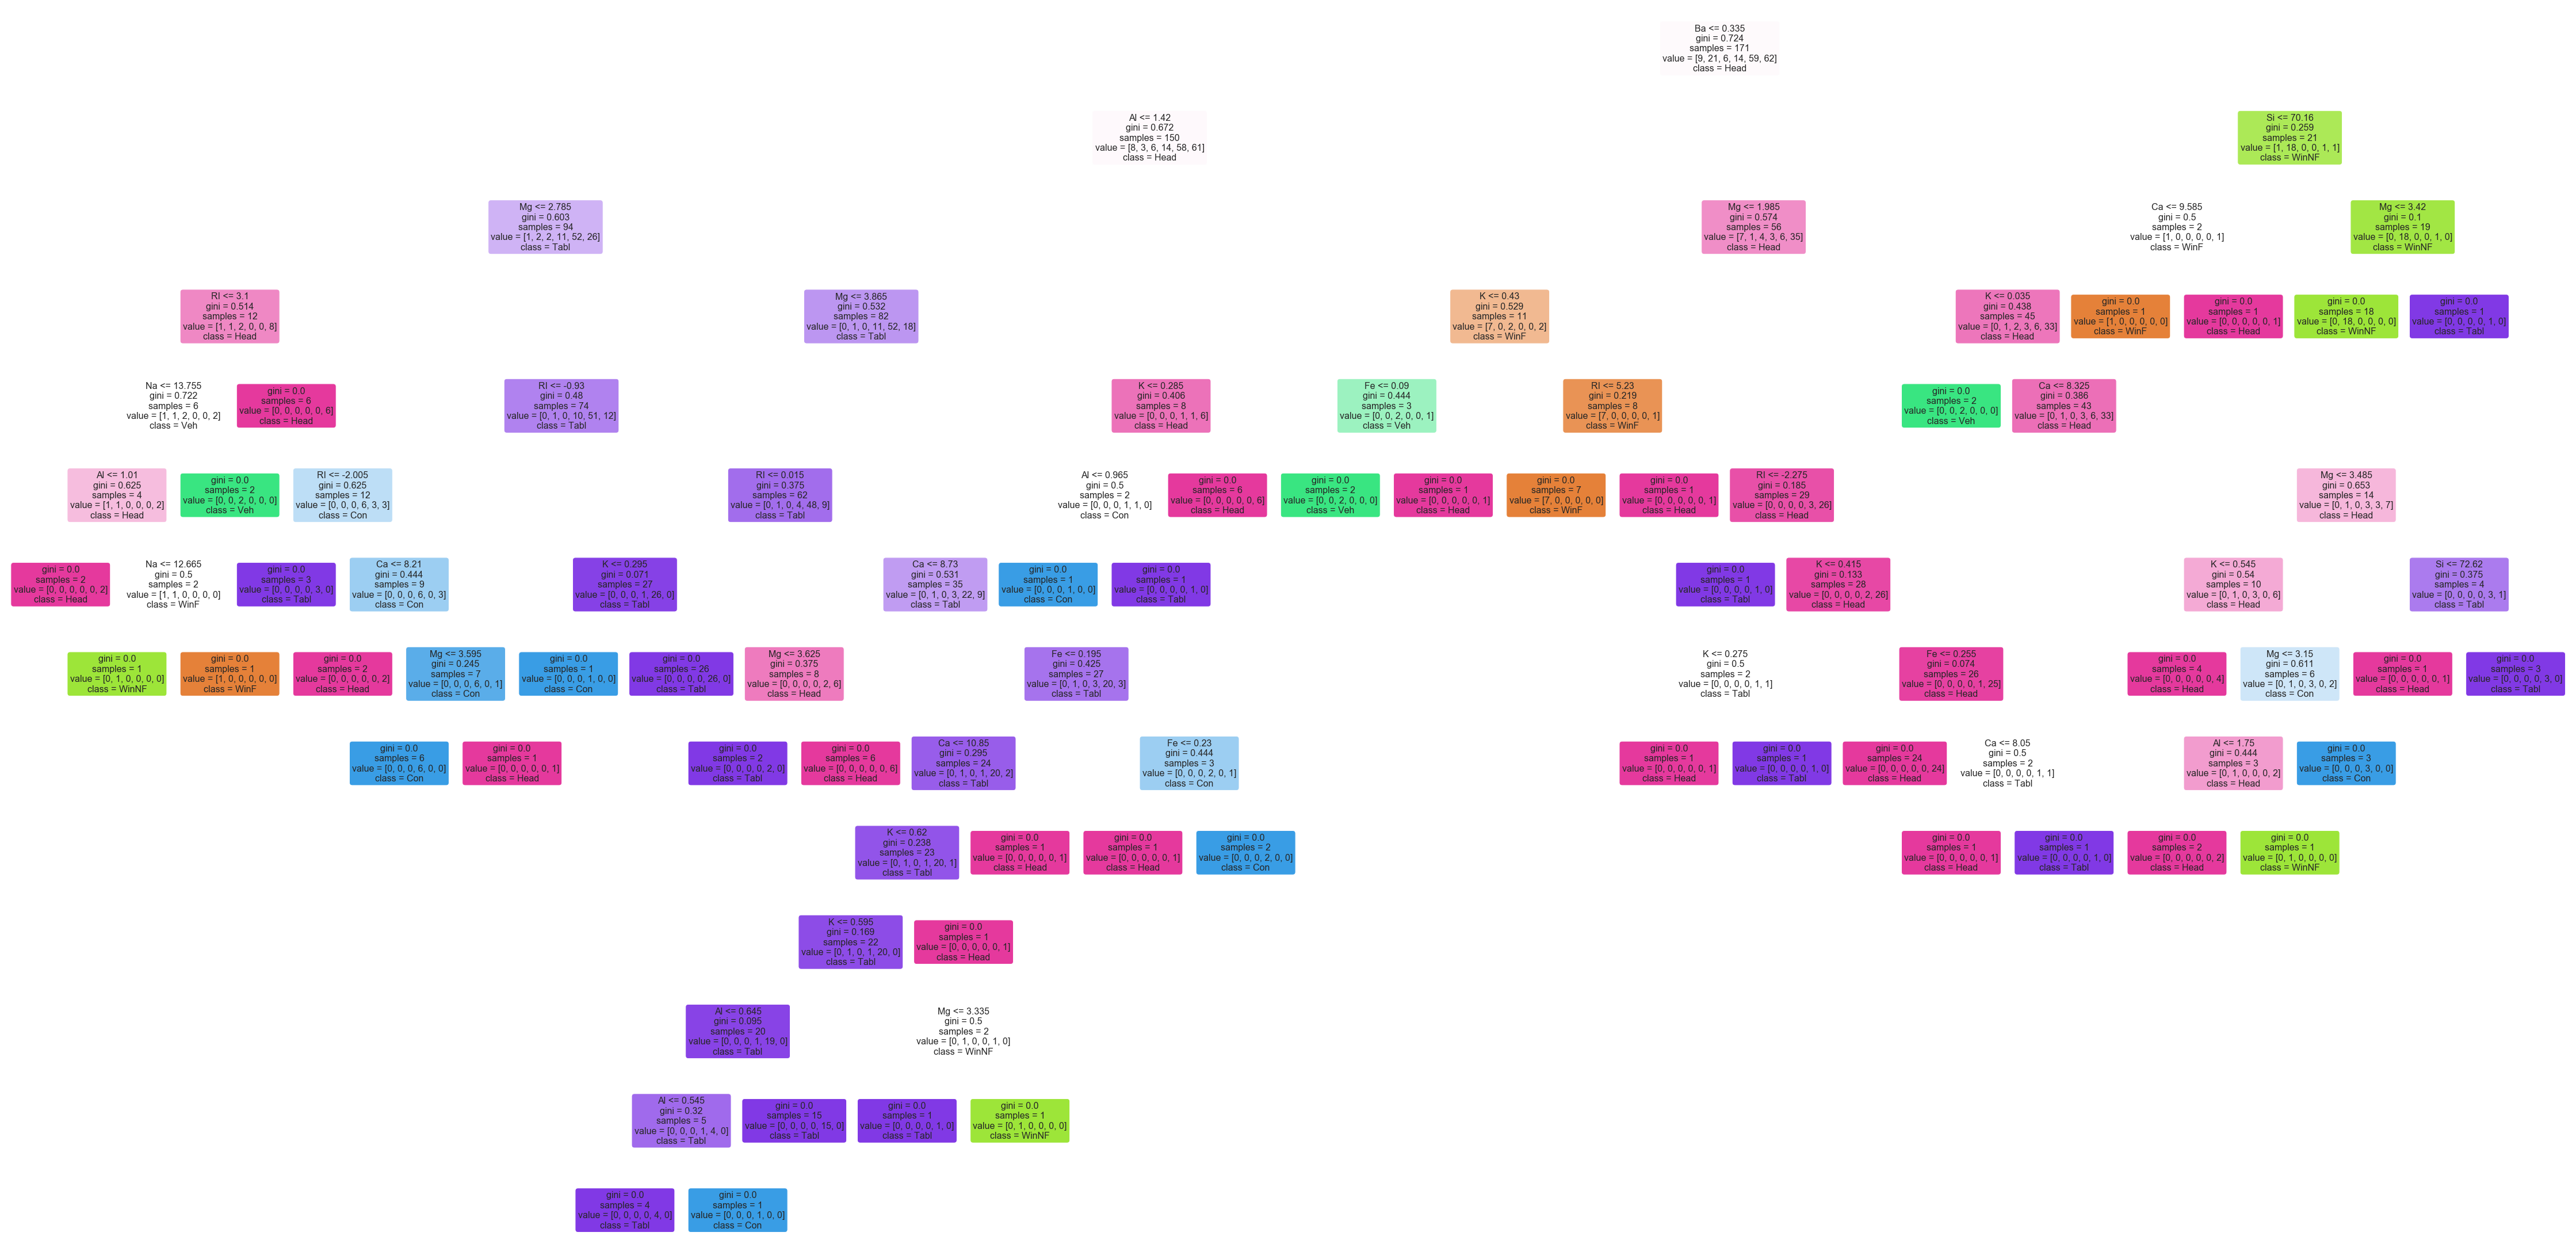

In [153]:
# sklearn.tree.export_graphviz(model, feature_names = X_data.columns)
plt.figure(figsize=(80,40))
sklearn.tree.plot_tree(model, 
                       class_names = classes,
                       feature_names = X_data.columns, 
                       filled=True, fontsize=16, rounded = True)
plt.show()

Интересно, деревья показали себя очень хорошо почти максимальная точность. Нужно проверить сохранится ли подобный качественный результат на кросс-валидации

In [135]:
scores = cross_val_score(model, 
                         X_data, y_data, cv=5, 
                         scoring=lambda m, x, y: recall_score(y, m.predict(x), average='macro'),
                         n_jobs=-1
                        )
print('Полнота взвешенная полученные на кроссвалидации:', ', '.join(['{0:0.2f}'.format(i) for i in scores]))

Полнота взвешенная полученные на кроссвалидации: 0.48, 0.63, 0.71, 0.64, 0.36


### Итоги
Деревья оказались достаточно хорошим вариантом для предсказания типа стекла.
Тип стекла удалось относительно качественно, но не очень стабильно (в плане кросс-валидации) предсказывать.
Если изучить дерево то можно увидеть, что дерево аналогично нам при анализе данных уделило такое же внимание нашим мелким находкам:
* Зависимость кальция и ri
* Количество бария для типа head
* и т.д.

К сожалению результаты оказываются достаточно не стабильными. Это есть несколько причин:
1. Количество данных очень мало - ~200 значений
    С таким количеством данных особо не получится разгуляться и попробовать, например нейронные сети или другие алгоритмы машинного обучения которым нужно "скармливать" много данных.
2. Классы распределенны не равномерно.
    WinF и WinNF - ~140 различных значений, что составляет больше 70% данных. Остальным просто может не хватать данных для достаточно точного обучения.
